In [11]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [12]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [13]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [14]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [15]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [16]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.000000,0.000350,0.002843,0.002793,0.004750,0.017648,0.008956,-0.009838
2005-02-01,0.005666,-0.003734,-0.005343,0.008802,0.010265,0.013544,0.006425,-0.003549
2005-02-02,0.003756,0.000117,0.002302,0.000884,-0.000668,0.009117,0.003192,0.002612
2005-02-03,-0.014967,-0.001757,-0.000875,-0.008056,-0.002676,0.010767,-0.001758,-0.012077
2005-02-04,0.004748,0.005280,0.014231,0.007231,0.003622,0.017877,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.008723,-0.003464,-0.009217,0.018423,-0.001273,0.012993,-0.005157,0.009863
2024-12-10,-0.005393,-0.001791,-0.004705,-0.016197,-0.008379,0.000855,-0.002896,0.013155
2024-12-11,0.014127,-0.002955,-0.009454,0.000000,0.004041,0.015805,0.007707,0.009247


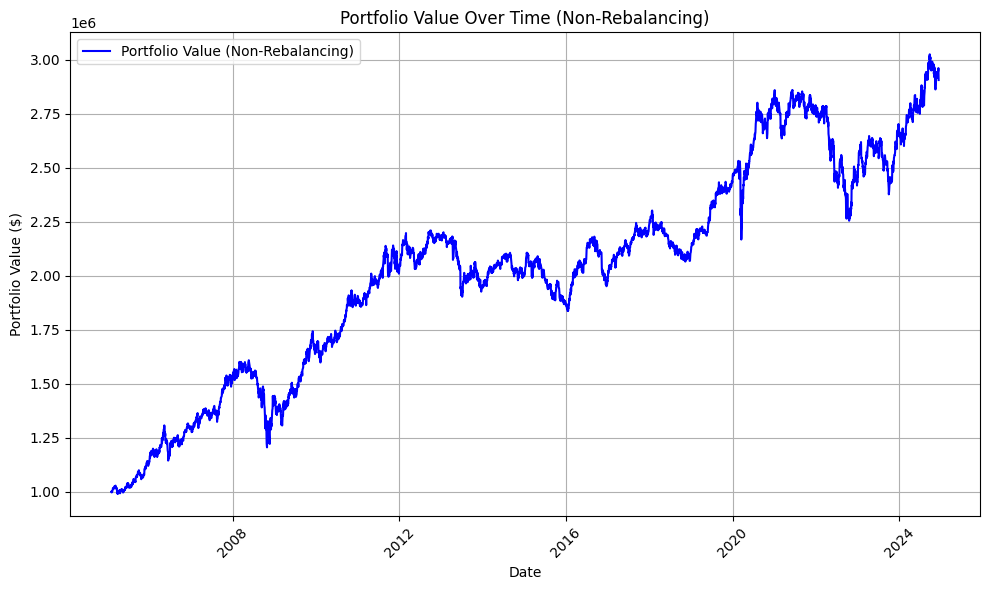

Final Portfolio Value (Non-Rebalancing): $2,906,814.33


In [17]:
#### 1/n Portfolio Construction Non-Rebalancing ####

weights = {
    'Japan': 1/15,
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
    'Gold': 1/3,
}

# Convert weights to a Series for alignment
weights_series = pd.Series(weights)

# Calculate daily portfolio returns
portfolio_return = (returns[weights_series.index] * weights_series).sum(axis=1)

# Calculate cumulative return
cumulative_return = (1 + portfolio_return).cumprod() - 1

# Initial investment
initial_investment_non_rebalancing = 1_000_000  # $1 million

# Calculate portfolio value over time (non-rebalanced)
portfolio_value_non_rebalancing = initial_investment_non_rebalancing * (1 + cumulative_return)

# Plot the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_non_rebalancing, label='Portfolio Value (Non-Rebalancing)', color='blue')
plt.title('Portfolio Value Over Time (Non-Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final portfolio value
final_value_non_rebalancing = portfolio_value_non_rebalancing.iloc[-1]
print(f"Final Portfolio Value (Non-Rebalancing): ${final_value_non_rebalancing:,.2f}")


In [18]:
#### 1/n Portfolio Analytics Non-Rebalancing ####

# Resample to monthly frequency and calculate monthly returns
monthly_returns_non_rebalancing = portfolio_value_non_rebalancing.resample('ME').ffill().pct_change().dropna()

# Calculate rolling annual volatility
rolling_annual_volatility_non_rebalancing = (
    monthly_returns_non_rebalancing.rolling(window=12).std() * np.sqrt(12)
)

# Calculate total return
total_return_non_rebalancing = (
    portfolio_value_non_rebalancing.iloc[-1] - portfolio_value_non_rebalancing.iloc[0]
) / portfolio_value_non_rebalancing.iloc[0]

# Geometric average monthly and yearly return
n_months = len(monthly_returns_non_rebalancing)
geo_avg_monthly_return_non_rebalancing = (
    (portfolio_value_non_rebalancing.iloc[-1] / portfolio_value_non_rebalancing.iloc[0])
    ** (1 / n_months) - 1
)
geo_avg_yearly_return_non_rebalancing = (1 + geo_avg_monthly_return_non_rebalancing) ** 12 - 1

# Sharpe Ratio
sharpe_ratio_non_rebalancing = (
    geo_avg_yearly_return_non_rebalancing / rolling_annual_volatility_non_rebalancing.mean()
)

# Calculate 99% Value at Risk (VaR)
VaR_99_non_rebalancing = monthly_returns_non_rebalancing.quantile(1 - 0.99)

# Print results for non-rebalancing portfolio
print(f"### 1/n Non-Rebalancing Portfolio Analytics ###")
print(f"Avg annualized monthly volatility: {rolling_annual_volatility_non_rebalancing.mean():.4f}")
print(f"Total return: {total_return_non_rebalancing * 100:.2f}%")
print(f"Geo avg monthly return: {geo_avg_monthly_return_non_rebalancing*100:.2f}%")
print(f"Geo avg yearly return: {geo_avg_yearly_return_non_rebalancing*100:.2f}%")
print(f"Total avg Sharpe Ratio: {sharpe_ratio_non_rebalancing:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_non_rebalancing:.4f}")


### 1/n Non-Rebalancing Portfolio Analytics ###
Avg annualized monthly volatility: 0.0942
Total return: 190.82%
Geo avg monthly return: 0.45%
Geo avg yearly return: 5.51%
Total avg Sharpe Ratio: 0.58
Monthly 99% Value at Risk (VaR): -0.0591


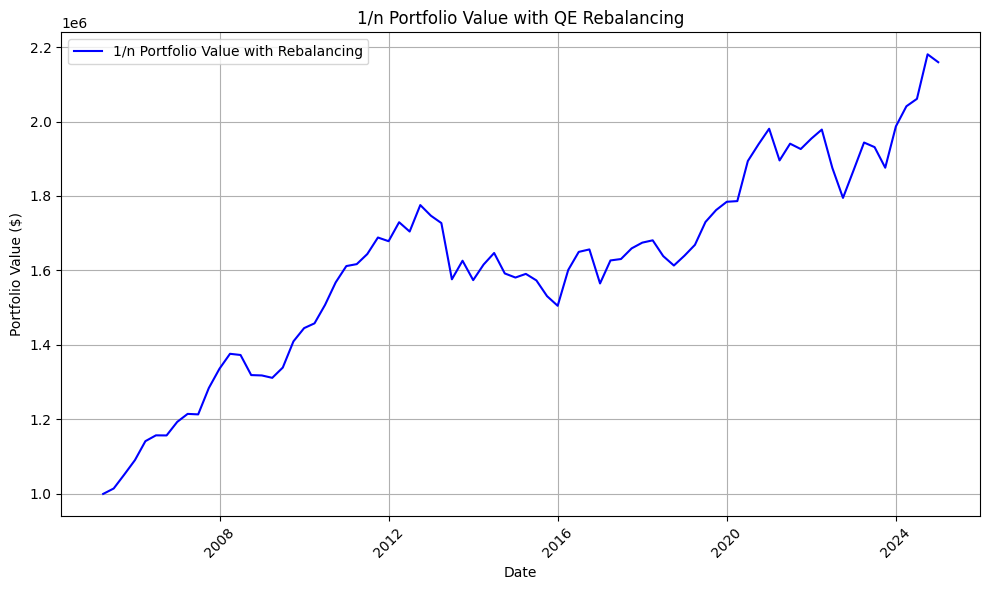

Final Portfolio Value (Rebalancing): $2,159,263.95


In [19]:
#### 1/n Portfolio Construction Rebalancing ####

# Define rebalancing frequency
rebalancing_frequency_rebalancing = 'QE'  # 'ME' = monthly, 'QE' = quarterly, 'YE' = yearly

# Define asset-class weights
asset_class_weights_rebalancing = {
    'equities': 1/3,
    'bonds': 1/3,
    'gold': 1/3,
}

# Equity and bond sub-weights
equity_weights_rebalancing = {
    'Japan': 1/15,
    'APACxJapan': 1/15,
    'Europe': 1/15,
    'LatAm': 1/15,
    'US': 1/15,
}
bond_weights_rebalancing = {
    'T-Bills_7_10': 1/6,
    'T-Bills_20': 1/6,
}

# Resample returns
resampled_returns_rebalancing = returns.resample(rebalancing_frequency_rebalancing).apply(lambda x: (1 + x).prod() - 1)

# Calculate weighted returns for each asset class
equity_weights_series_rebalancing = pd.Series(equity_weights_rebalancing)
monthly_equity_returns_rebalancing = (
    resampled_returns_rebalancing[equity_weights_series_rebalancing.index] * equity_weights_series_rebalancing
).sum(axis=1)

bond_weights_series_rebalancing = pd.Series(bond_weights_rebalancing)
monthly_bond_returns_rebalancing = (
    resampled_returns_rebalancing[bond_weights_series_rebalancing.index] * bond_weights_series_rebalancing
).sum(axis=1)

monthly_gold_returns_rebalancing = resampled_returns_rebalancing['Gold']

# Initialize the portfolio with 1 million
initial_investment_rebalancing = 1_000_000
portfolio_value_rebalancing = pd.Series(index=resampled_returns_rebalancing.index)
portfolio_value_rebalancing.iloc[0] = initial_investment_rebalancing

# Portfolio rebalancing loop
for i in range(1, len(resampled_returns_rebalancing)):
    portfolio_return_rebalancing = (
        asset_class_weights_rebalancing['equities'] * monthly_equity_returns_rebalancing.iloc[i]
        + asset_class_weights_rebalancing['bonds'] * monthly_bond_returns_rebalancing.iloc[i]
        + asset_class_weights_rebalancing['gold'] * monthly_gold_returns_rebalancing.iloc[i]
    )

    # Update portfolio value
    prev_value_rebalancing = portfolio_value_rebalancing.iloc[i - 1]
    portfolio_value_rebalancing.iloc[i] = prev_value_rebalancing * (1 + portfolio_return_rebalancing)

# Plot the portfolio value
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_rebalancing, label='1/n Portfolio Value with Rebalancing', color='blue')
plt.title(f'1/n Portfolio Value with {rebalancing_frequency_rebalancing} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final portfolio value
final_value_rebalancing = portfolio_value_rebalancing.iloc[-1]
print(f"Final Portfolio Value (Rebalancing): ${final_value_rebalancing:,.2f}")


In [20]:
#### 1/n Portfolio Analytics Rebalancing ####

# Calculate monthly returns from the portfolio value (rebalanced)
monthly_portfolio_value_rebalancing = portfolio_value_rebalancing.resample('ME').ffill()
monthly_returns_rebalancing = monthly_portfolio_value_rebalancing.pct_change().dropna()

# Calculate rolling annual volatility
rolling_annual_volatility_rebalancing = (
    monthly_returns_rebalancing.rolling(window=12).std() * np.sqrt(12)
)

# Calculate total return
total_return_rebalancing = (
    portfolio_value_rebalancing.iloc[-1] - portfolio_value_rebalancing.iloc[0]
) / portfolio_value_rebalancing.iloc[0]

# Geo Average monthly and yearly returns
n_months = len(monthly_returns_rebalancing)
geo_avg_monthly_return_rebalancing = (
    (portfolio_value_rebalancing.iloc[-1] / portfolio_value_rebalancing.iloc[0])
    ** (1 / n_months) - 1
)
geo_avg_yearly_return_rebalancing = (1 + geo_avg_monthly_return_rebalancing) ** 12 - 1

# Sharpe Ratio
sharpe_ratio_rebalancing = (
    geo_avg_yearly_return_rebalancing / rolling_annual_volatility_rebalancing.mean()
)

# Calculate 99% Value at Risk (VaR)
VaR_99_rebalancing = monthly_returns_rebalancing.quantile(1 - 0.99)

# Print results for rebalancing portfolio
print(f"### 1/n Rebalancing Portfolio Analytics ###")
print(f"Avg annualized monthly volatility: {rolling_annual_volatility_rebalancing.mean():.4f}")
print(f"Total return: {total_return_rebalancing * 100:.2f}%")
print(f"Geo avg monthly return: {geo_avg_monthly_return_rebalancing*100:.2f}%")
print(f"Geo avg yearly return: {geo_avg_yearly_return_rebalancing*100:.2f}%")
print(f"Total avg Sharpe Ratio: {sharpe_ratio_rebalancing:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_rebalancing:.4f}")
#1/n is now final

### 1/n Rebalancing Portfolio Analytics ###
Avg annualized monthly volatility: 0.0583
Total return: 115.93%
Geo avg monthly return: 0.33%
Geo avg yearly return: 3.97%
Total avg Sharpe Ratio: 0.68
Monthly 99% Value at Risk (VaR): -0.0488
